### Repeated-measures ANOVA example with 3 levels and 1 factor

Based on [Crosse et al (2015)](https://www.jneurosci.org/content/35/42/14195.full)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

In [26]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of subjects and levels
n_subjects = 20
levels = ['AV','A','V']
n_levels = len(levels)

# Mean values and standard deviation for each level
means = [600, 650, 800]
std_dev_sbj = 100 # this is the variability across participants
std_dev_wthn = 30 # this is the variability within participants

# Simulate data ensuring values are between 0 and 100
data = []
for subject in range(1, n_subjects + 1):
    sbj_avg = np.random.normal(0, std_dev_sbj)
    for level in range(1, n_levels + 1):
        value = np.random.normal(means[level - 1], std_dev_wthn)
        value = value+sbj_avg  # Ensure value is between 0 and 100
        data.append([subject, levels[level-1], value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Response time'])

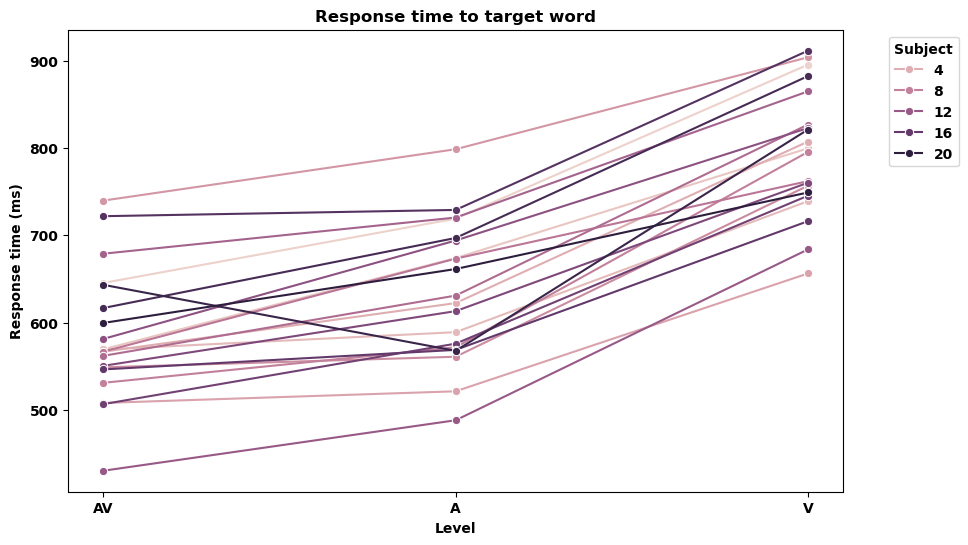

In [27]:
# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Condition', y='Response time', hue='Subject', marker='o')
plt.title('Response time to target word')
plt.xlabel('Level')
plt.ylabel('Response time (ms)')
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [25]:
# Run the repeated-measures ANOVA
aov = pg.rm_anova(dv='Response time', within='Condition', subject='Subject', data=df, detailed=True)
print(aov)

      Source             SS  DF             MS           F         p-unc  \
0  Condition  485471.971850   2  242735.985925  273.711939  2.716127e-23   
1      Error   33699.543699  38     886.830097         NaN           NaN   

        ng2       eps  
0  0.599725  0.992259  
1       NaN       NaN  
